# Задание 1

**ОСНОВНАЯ ЦЕЛЬ:**

A/B-тестирование: анализ результатов эксперимента, которые зафиксированы в датасете data_ab.csv, — проверка наличия статистически и практически значимых различий между наблюдениями в контрольной и экспериментальной группах.

**ПЛАН**

По замыслу A/B-теста контрольной группе (control) должна была показываться старая версия лендинга — old_page; экспериментальной группе (treatment) должна была показываться новая версия лендинга — new_page.

1. понять структуру данных, провести **EDA** и **выбрать метрику**, с которой будете
работать;

2. проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);

3. **сформулировать нулевую и альтернативную гипотезы** на основании выбранной метрики;

4. выбрать и обосновать статистический тест;
решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;
5. оценить разницу в результатах и сделать выводы о практической значимости эксперимента;
6. провести дополнительный анализ при необходимости (например, с помощью bootstrap или через анализ чувствительности);
7. сформулировать рекомендации и **бизнес-инсайты** по результатам эксперимента.

**учёта в значительной степени временной составляющей эксперимента.**

обоснованного применения дополнительных инструментов/подходов для анализа результатов A/B-тестирования, не упомянутых ранее в этом ноутбуке и не рассматривавшихся в рамках соответствующего семинара и лекции (**bootstrap'a или анализа чувствительности** может хватить на 3 балла при условии корректного и осмысленного их применения).

In [592]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler
import matplotlib as mpl

## EDA

### Скачиваем

In [594]:
df = pd.read_csv("data_ab.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [595]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


у нас timestamp имеет тип объекта object, что неверно, ведь это дата

сразу исправим

In [596]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [597]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


### Чистим дубликаты

In [598]:
print(f"Изначально: {len(df)}")

df_no_full_dupes = df.drop_duplicates()
rows1 = df_no_full_dupes.shape[0]
print(f"После удаления полных дублей: {rows1}")

Изначально: 294478
После удаления полных дублей: 294478


полных дубликатов нет, чек дубликаты по user

In [599]:
dupes_id = df["user_id"].value_counts()
dupes_id

,count
user_id,
752737,2
781280,2
767913,2
886060,2
731779,2
...,...
653383,1
732573,1
867433,1


In [600]:
dupes_id = dupes_id[dupes_id > 1].index
dupes_rows = df[df["user_id"].isin(dupes_id)]
df2 = dupes_rows.sort_values(by="user_id")

df2

,user_id,timestamp,group,landing_page,converted
213114,630052,2025-01-07 12:25:54.089486,treatment,old_page,1
230259,630052,2025-01-17 01:16:05.208766,treatment,new_page,0
251762,630126,2025-01-19 17:16:00.280440,treatment,new_page,0
22513,630126,2025-01-14 13:35:54.778695,treatment,old_page,0
11792,630137,2025-01-22 14:59:22.051308,control,new_page,0
...,...,...,...,...,...
99479,945703,2025-01-18 06:39:31.294688,control,old_page,0
186960,945797,2025-01-13 17:23:21.750962,control,old_page,0
40370,945797,2025-01-11 03:04:49.433736,control,new_page,1
165143,945971,2025-01-16 10:09:18.383183,control,old_page,0


видим, что есть строки, где у user treatment и old_page и new_page и ан-но control

In [601]:
df2.groupby(["group", "landing_page"]).size()

group      landing_page
control    new_page        1928
           old_page        1981
treatment  new_page        1914
           old_page        1965
dtype: int64

у control должно быть old_page, а у treatment - new_page по усл

поместим неправильные в отд датасет

In [602]:
mask = (
    ((df["group"] == "treatment") & (df["landing_page"] == "old_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "new_page"))
)

df_mist = df[mask]

In [603]:
df_mist.sort_values("timestamp")

,user_id,timestamp,group,landing_page,converted
291728,828985,2025-01-02 13:55:08.790046,control,new_page,0
167601,787103,2025-01-02 14:03:33.543019,control,new_page,0
194773,694909,2025-01-02 14:05:08.848519,control,new_page,0
23279,750558,2025-01-02 14:06:46.989262,control,new_page,0
146523,762515,2025-01-02 14:44:53.517658,control,new_page,0
...,...,...,...,...,...
51862,709466,2025-01-24 12:56:11.808544,control,new_page,0
39395,732074,2025-01-24 13:04:22.448451,control,new_page,0
170943,797801,2025-01-24 13:12:58.139993,treatment,old_page,0
228167,670745,2025-01-24 13:25:28.589447,control,new_page,0


In [604]:
df_clean = df[~mask]
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


проверим нет ли больше дубликатов

In [605]:
dupes_id = df_clean["user_id"].value_counts()
dupes_id = dupes_id[dupes_id > 1]

dupes_id

,count
user_id,
773192,2


In [606]:
df_clean[df_clean["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2025-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0


чел заходил 2 раза на сайт и оба раза не зарегался, поэтому удалим один из его заходов, так как не влияет

In [607]:
idx = df_clean[df_clean["user_id"] == 773192].index[0]
df_clean = df_clean.drop(idx)

In [608]:
df = df_clean
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


### Пропуски чекаем (их нет)

In [609]:
df.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


### чек ошибочные (нет)

In [610]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [611]:
print(df["group"].unique())
print(df["landing_page"].unique())
print(df["converted"].unique())

['control' 'treatment']
['old_page' 'new_page']
[0 1]


нет ошибочных

### чек выбросы и распределения каждого признака

нет выбросов, все распределено равномерно

#### timestamp

посмотрим на столбец timestamp

In [612]:
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour

df.head()

,user_id,timestamp,group,landing_page,converted,date,hour
0,851104,2025-01-21 22:11:48.556739,control,old_page,0,2025-01-21,22
1,804228,2025-01-12 08:01:45.159739,control,old_page,0,2025-01-12,8
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0,2025-01-11,16
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0,2025-01-08,18
4,864975,2025-01-21 01:52:26.210827,control,old_page,1,2025-01-21,1


In [613]:
df = df.sort_values("timestamp")
df

,user_id,timestamp,group,landing_page,converted,date,hour
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13
...,...,...,...,...,...,...,...
158814,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,2025-01-24,13
47535,808330,2025-01-24 13:41:19.152664,control,old_page,0,2025-01-24,13
157787,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,2025-01-24,13
179072,836373,2025-01-24 13:41:52.604673,control,old_page,0,2025-01-24,13


так как вы видим, что у нас один год - 2025 и один месяц - январь, то нас интересует по сути только день и можно еще посмотреть день недели

In [614]:
df["day"] = df["timestamp"].dt.day
df.head()

,user_id,timestamp,group,landing_page,converted,date,hour,day
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13,2
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13,2
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13,2
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13,2
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13,2


In [615]:
df["weekday_num"] = df["timestamp"].dt.weekday
df

,user_id,timestamp,group,landing_page,converted,date,hour,day,weekday_num
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13,2,3
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13,2,3
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13,2,3
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13,2,3
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13,2,3
...,...,...,...,...,...,...,...,...,...
158814,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,2025-01-24,13,24,4
47535,808330,2025-01-24 13:41:19.152664,control,old_page,0,2025-01-24,13,24,4
157787,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,2025-01-24,13,24,4
179072,836373,2025-01-24 13:41:52.604673,control,old_page,0,2025-01-24,13,24,4


In [616]:
df["weekday_num"].value_counts()

,count
weekday_num,
4,47148
3,45439
2,39915
1,39670
0,39626
5,39565
6,39221


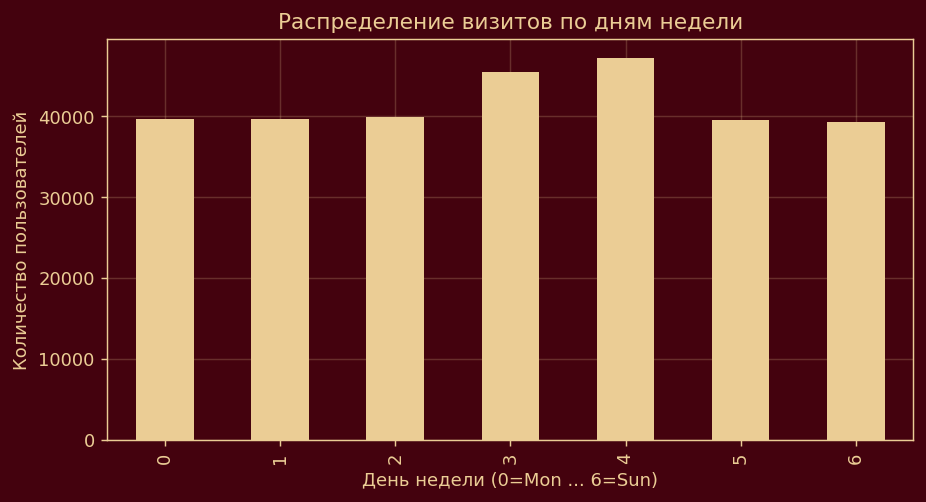

In [617]:
weekday_counts = df["weekday_num"].value_counts().sort_index()

plt.figure(figsize=(8,4))
weekday_counts.plot(kind="bar")

plt.xlabel("День недели (0=Mon ... 6=Sun)")
plt.ylabel("Количество пользователей")
plt.title("Распределение визитов по дням недели")
plt.show()

In [618]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 131228 to 193652
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
 5   date          290584 non-null  object        
 6   hour          290584 non-null  int32         
 7   day           290584 non-null  int32         
 8   weekday_num   290584 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(2), object(3)
memory usage: 18.8+ MB


In [619]:
df["timestamp"].describe()

,timestamp
count,290584
mean,2025-01-13 13:42:03.906819584
min,2025-01-02 13:42:05.378582
25%,2025-01-08 02:06:43.829340672
50%,2025-01-13 13:21:45.577577728
75%,2025-01-19 01:49:46.966643968
max,2025-01-24 13:41:54.460509


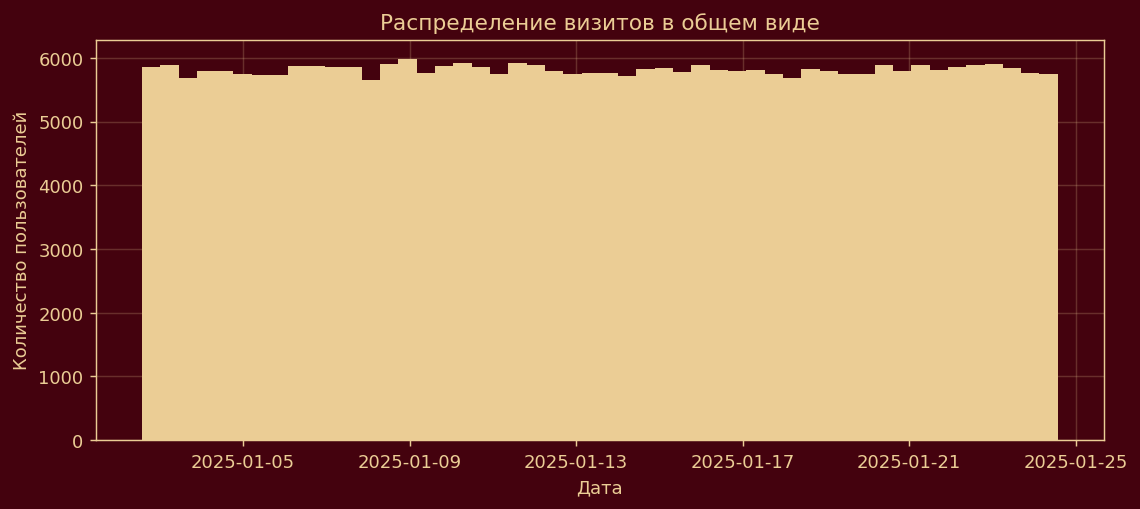

In [620]:
plt.figure(figsize=(10,4))
df["timestamp"].hist(bins=50)
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.title("Распределение визитов в общем виде")
plt.show()

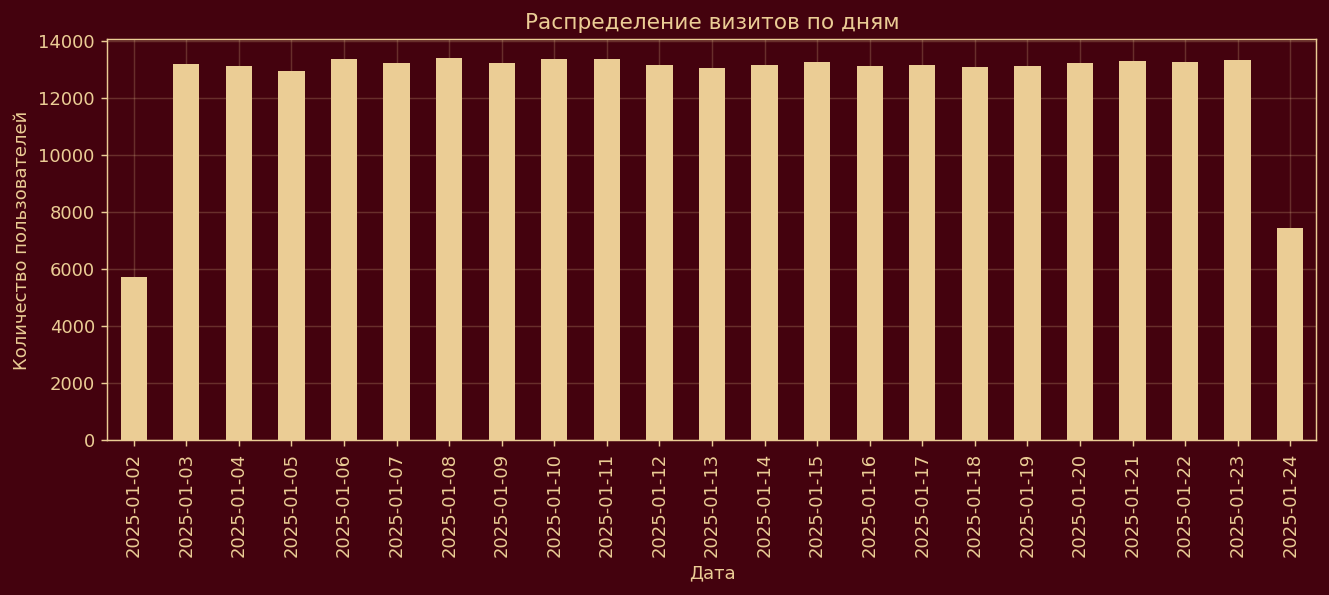

In [621]:
date_counts = df["date"].value_counts().sort_index()

date_counts.plot(kind="bar", figsize=(12,4))
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.title("Распределение визитов по дням")
plt.show()

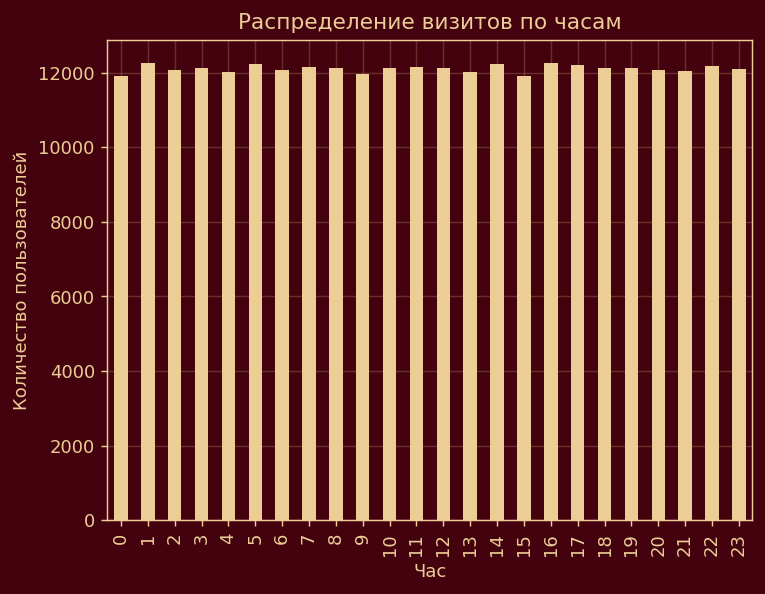

In [622]:
hour_counts = df["hour"].value_counts().sort_index()

hour_counts.plot(kind="bar")
plt.xlabel("Час")
plt.ylabel("Количество пользователей")
plt.title("Распределение визитов по часам")
plt.show()

время распределено в целом равномерно, нет никаких выбросов

#### group и landing_page

так как мы оставили, что каждой группе соответствует своя страница, то у них совпадают распределния

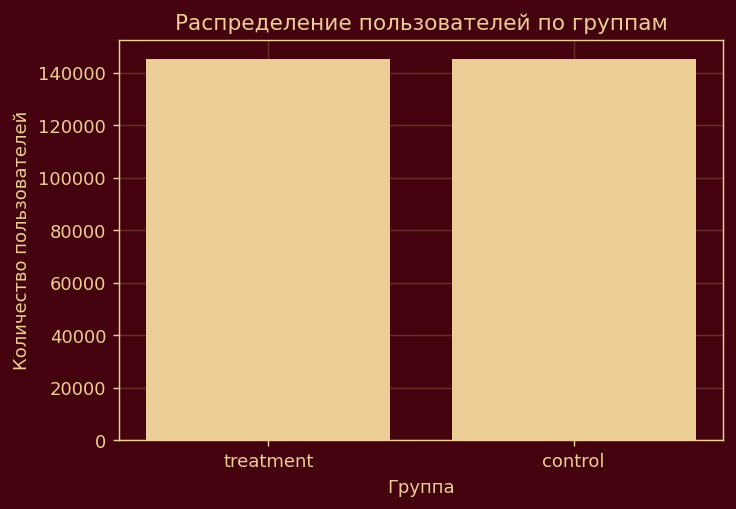

In [623]:
group_counts = df_clean["group"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(group_counts.index, group_counts.values)

plt.xlabel("Группа")
plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по группам")

plt.show()

#### converted

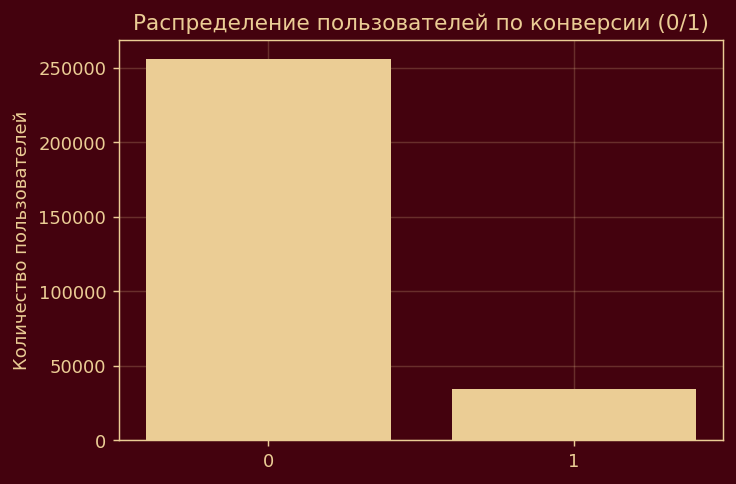

In [640]:
counts = df_clean["converted"].value_counts().sort_index()
labels = ["0", "1"]

plt.figure(figsize=(6,4))
plt.bar(labels, counts.values)

plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по конверсии (0/1)")
plt.show()

### fe

удалим ненужные столбцы

In [625]:
df = df.drop(columns=["user_id", "timestamp", "landing_page", "date"])
df.head()

,group,converted,hour,day,weekday_num
131228,treatment,0,13,2,3
184884,control,0,13,2,3
83878,control,0,13,2,3
102717,treatment,0,13,2,3
158789,treatment,0,13,2,3


особых зависимотсей не выявлено

## ВЫБОР МЕТРИКИ

Ключевая метрика - конверсия, потому что именно она отражает, что нам важно в этом A/B-тесте: какая доля пользователей совершила целевое действие. Все изменения в продукте оцениваются через изменение конверсии.

#### Связь метрики с другими признаками

In [626]:
df_conv1 = df[df["converted"] == 1]

In [627]:
df_conv1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34753 entries, 126997 to 260161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   group        34753 non-null  object
 1   converted    34753 non-null  int64 
 2   hour         34753 non-null  int32 
 3   day          34753 non-null  int32 
 4   weekday_num  34753 non-null  int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 1.2+ MB


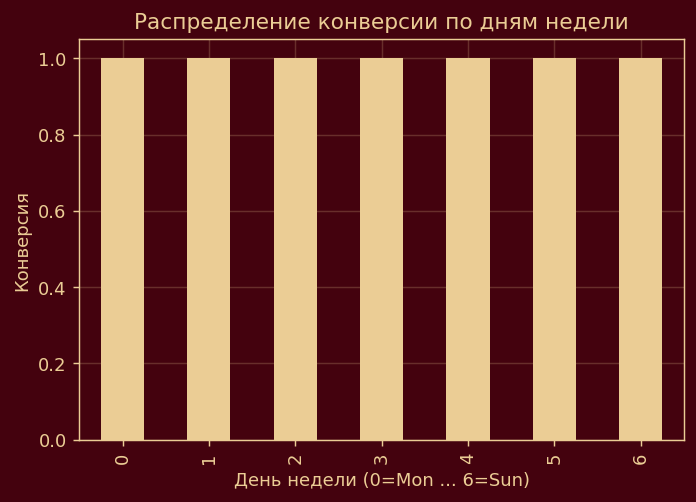

In [643]:
conv_by_weekday = ( df_conv1.groupby("weekday_num")["converted"].mean().sort_index())

plt.figure(figsize=(6,4))
conv_by_weekday.plot(kind="bar")
plt.xlabel("День недели (0=Mon ... 6=Sun)")
plt.ylabel("Конверсия")
plt.title("Распределение конверсии по дням недели")
plt.show()

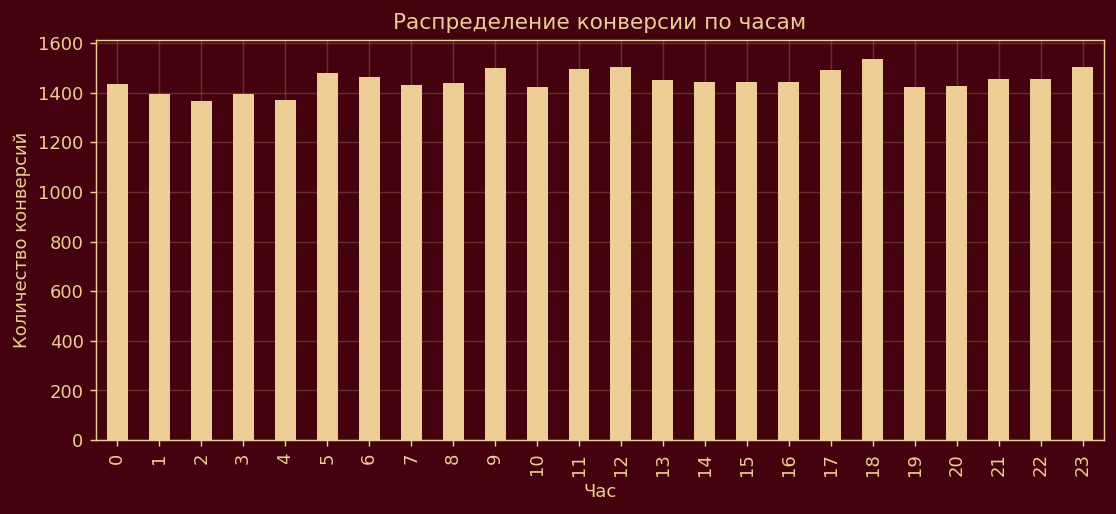

In [644]:
hour_counts = (df_conv1["hour"].value_counts().sort_index())

plt.figure(figsize=(10,4))
hour_counts.plot(kind="bar")
plt.xlabel("Час")
plt.ylabel("Количество конверсий")
plt.title("Распределение конверсии по часам")
plt.show()

## КОРРЕКТНОСТЬ ПРОВЕДЕНИЯ ТЕСТИРОВАНИЯ

#### разбиваем на группы

In [630]:
gra = df[df["group"] == "control"]
grb = df[df["group"] == "treatment"]

In [631]:
gra = gra.drop(columns="group").reset_index()
gra

,index,converted,hour,day,weekday_num
0,184884,0,13,2,3
1,83878,0,13,2,3
2,112584,0,13,2,3
3,126997,1,13,2,3
4,189698,0,13,2,3
...,...,...,...,...,...
145269,260161,1,13,24,4
145270,180924,0,13,24,4
145271,47535,0,13,24,4
145272,179072,0,13,24,4


In [632]:
grb = grb.drop(columns="group").reset_index()
grb

,index,converted,hour,day,weekday_num
0,131228,0,13,2,3
1,102717,0,13,2,3
2,158789,0,13,2,3
3,191378,0,13,2,3
4,111830,0,13,2,3
...,...,...,...,...,...
145305,156537,0,13,24,4
145306,225633,0,13,24,4
145307,29690,0,13,24,4
145308,158814,0,13,24,4


In [633]:
print(len(gra))
print(len(grb))

145274
145310


#### однородность групп (распределения по признакам) (да)

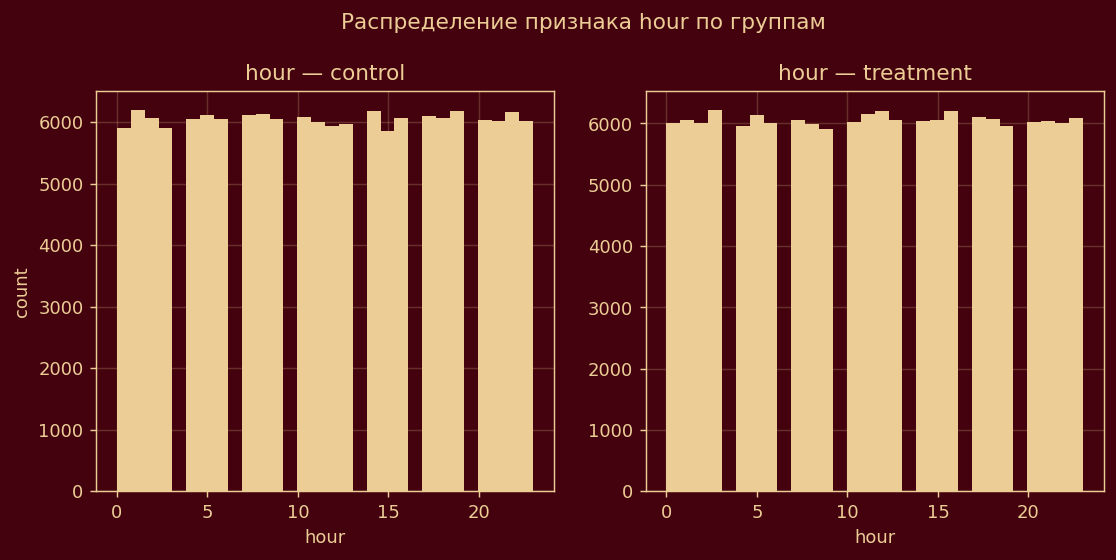

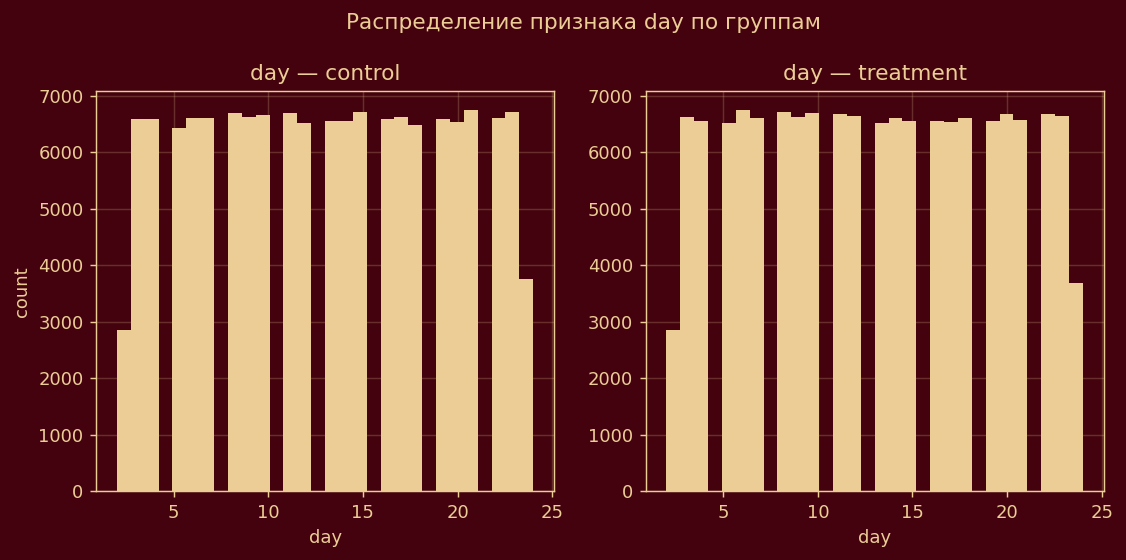

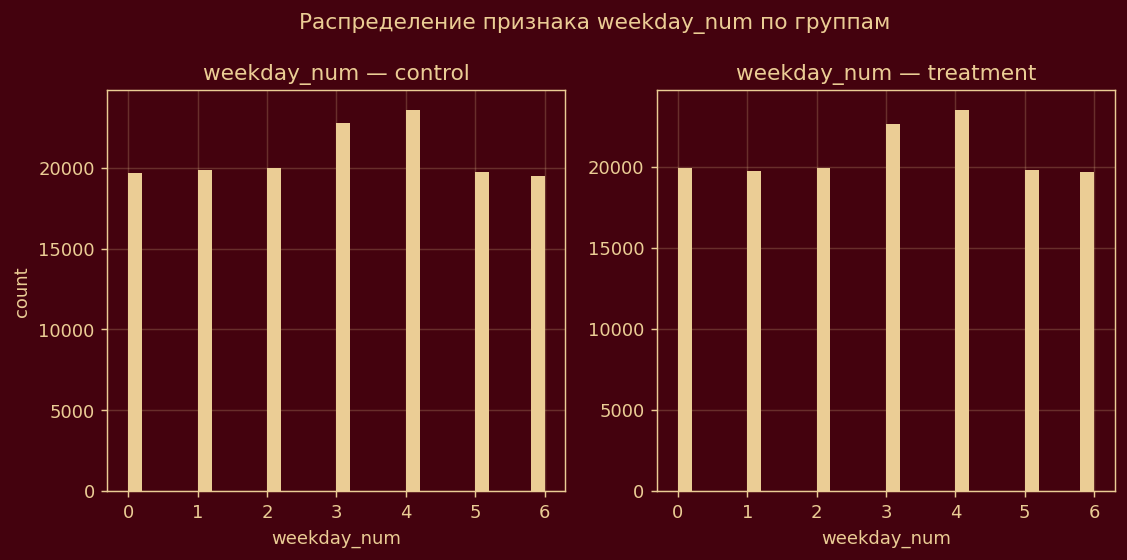

In [634]:
cols = ["hour", "day", "weekday_num"]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].hist(gra[col], bins=30)
    axes[0].set_title(f"{col} — control")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("count")

    axes[1].hist(grb[col], bins=30)
    axes[1].set_title(f"{col} — treatment")
    axes[1].set_xlabel(col)

    fig.suptitle(f"Распределение признака {col} по группам", y=1.03)
    plt.show()

In [635]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 131228 to 193652
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   group        290584 non-null  object
 1   converted    290584 non-null  int64 
 2   hour         290584 non-null  int32 
 3   day          290584 non-null  int32 
 4   weekday_num  290584 non-null  int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 10.0+ MB


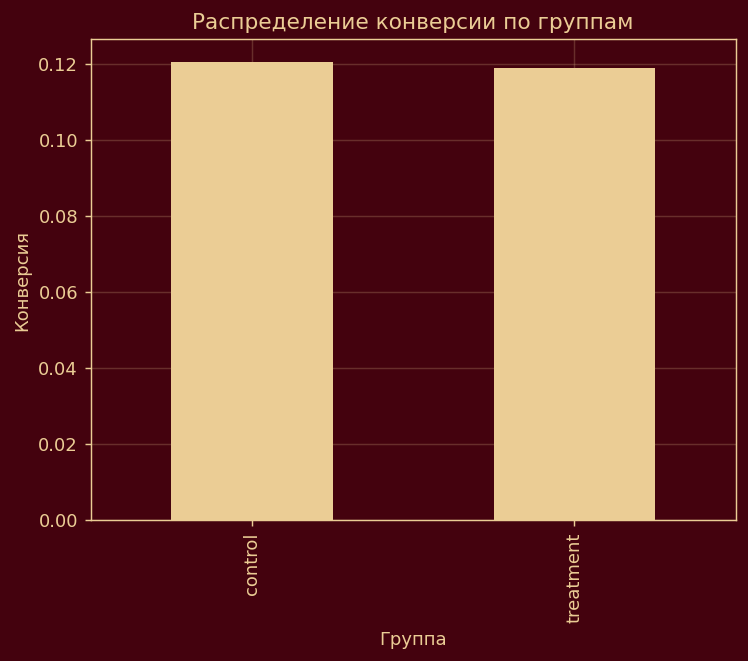

In [645]:
conv_by_group = df.groupby("group")["converted"].mean()

conv_by_group.plot(kind="bar")
plt.ylabel("Конверсия")
plt.xlabel("Группа")
plt.title("Распределение конверсии по группам")
plt.show()

группы по признакам однородны

#### сравнение связей метрики с параметрами по группам

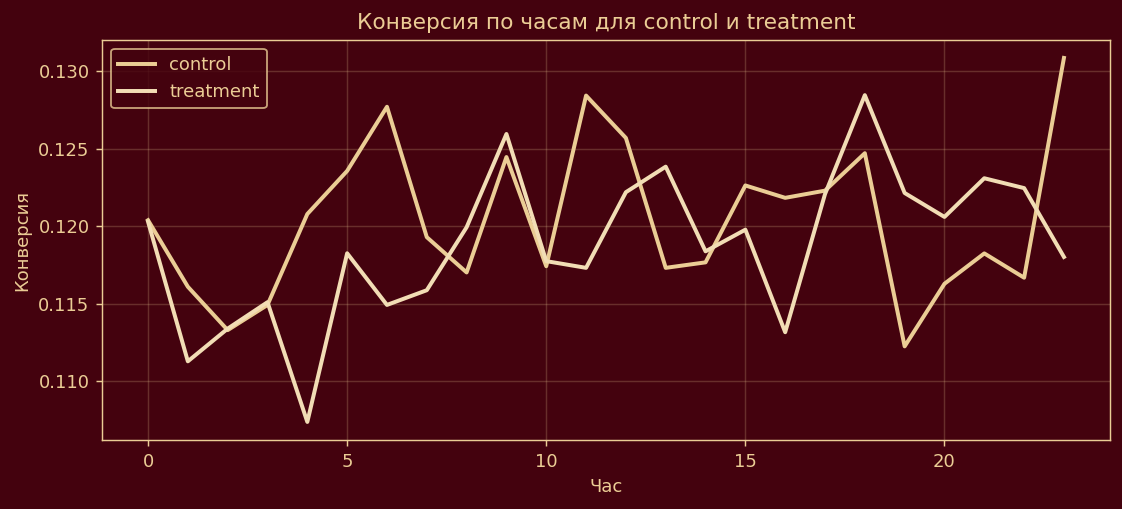

In [637]:
conv_hour_gra = gra.groupby("hour")["converted"].mean()
conv_hour_grb = grb.groupby("hour")["converted"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("Час")
plt.ylabel("Конверсия")
plt.title("Конверсия по часам для control и treatment")
plt.legend()
plt.show()

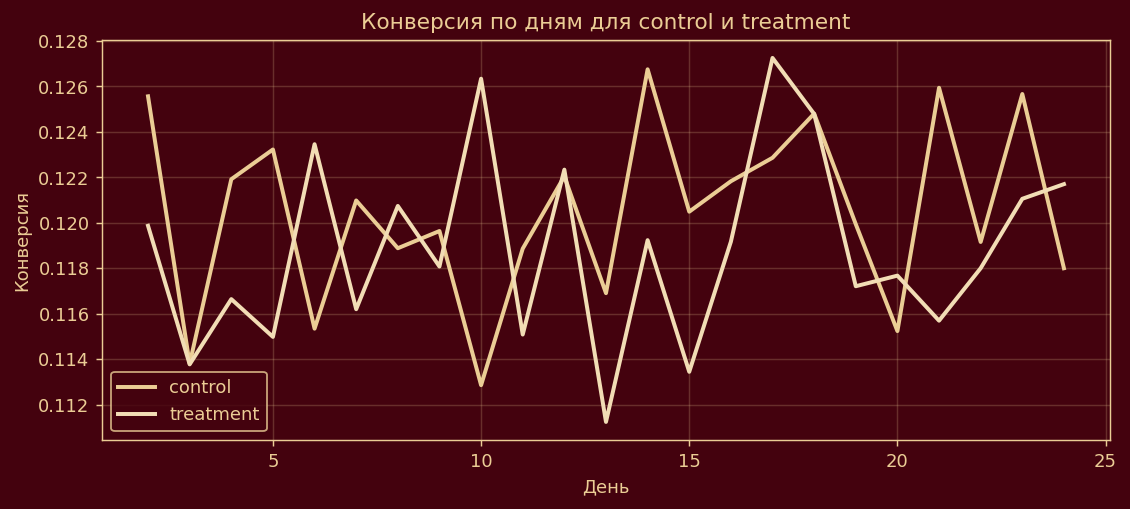

In [638]:
conv_hour_gra = gra.groupby("day")["converted"].mean()
conv_hour_grb = grb.groupby("day")["converted"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("День")
plt.ylabel("Конверсия")
plt.title("Конверсия по дням для control и treatment")
plt.legend()
plt.show()

### AA тест (подтвердить что сплит система сработала хорошо)

но у нас уже проведем A/B тест так что надобноти в AA тесте нет

## ГИПОТЕЗЫ

H0 (нулевая гипотеза) - Средняя конверсия (доля пользователей, совершивших целевое действие) в контрольной и тестовой группе одинакова.

H1 (альтернативная гипотеза) - Средняя конверсия в тестовой группе отличается от конверсии в контрольной группе.


# ПАРАМЕТРЫ КОТОРЫЕ ДОЛЖНЫ БЫТЬ ОПРЕДЕЛЕНЫ ЗАРАНЕЕ

**Уровень значимости (α) = 0,05**

Это вероятность ошибки первого рода - ситуации, когда мы ошибочно отвергаем нулевую гипотезу (то есть считаем, что есть эффект, хотя его нет)

**β = 0,2**

Это вероятность ошибки второго рода, то есть вероятность того, что мы не заметим эффект, даже если он на самом деле есть

**Мощность (1 − β) = 0,8**

Это вероятность обнаружить реальный эффект, если он действительно существует.


мощность показывает, с какой вероятностью тест правильно отвергнет нулевую гипотезу в ситуации, когда она неверна.

# СТАТИСТИЧЕСКИЙ ТЕСТ

In [639]:
from statsmodels.stats.proportion import proportions_ztest

stat, p_value = proportions_ztest([gra["converted"].sum(), grb["converted"].sum()], [len(gra), len(grb)])
print(f"Статистика теста: {stat}, p-значение: {p_value}")

Статистика теста: 1.3109241984234394, p-значение: 0.18988337448195103


метрика - бинарная (конверсия), так что используем z-test для пропорций

У нас нет оснований отвергнуть нулевую гипотезу (pvalue = 0.19 > 0.05)

Статистически значимой разницы конверсии между control и treatment по данным этого эксперимента не обнаружено

# Bootstrap


Ранее сравнение конверсий между группами проводилось с использованием статистических тестов. Далее для более детального анализа эффекта и оценки возможного диапазона значений разницы конверсий применим алгоритм bootstrap:

In [587]:
b = 2000
d = []

for i in range(b):
    c = gra.sample(frac=1, replace=True)
    t = grb.sample(frac=1, replace=True)

    pc = c['converted'].mean()
    pt = t['converted'].mean()

    d.append(pt - pc)

d = np.array(d)

eff = grb['converted'].mean() - gra['converted'].mean()

lo, hi = np.percentile(d, [2.5, 97.5])

print(f'Насколько отличаются конверсии: {eff}')
print(f'Границы 95% доверительного интервала: [{lo}, {hi}]')


Насколько отличаются конверсии: -0.0015782389853555567
Границы 95% доверительного интервала: [-0.0040014116992815735, 0.0008855169564005588]


Можно заметить, что статистически значимого эффекта разности конверсий между контрольной и экспериментальной группами нет. Оценка разницы конверсий составляет -0.00277, то есть в группе treatment конверсия немного ниже. Однако 95% доверительный интервал для разности конверсий равен [−0.00941; 0.00383] и содержит ноль, что говорит об отсутствии статистически значимых различий между группами.

Рассмотрим визуально:



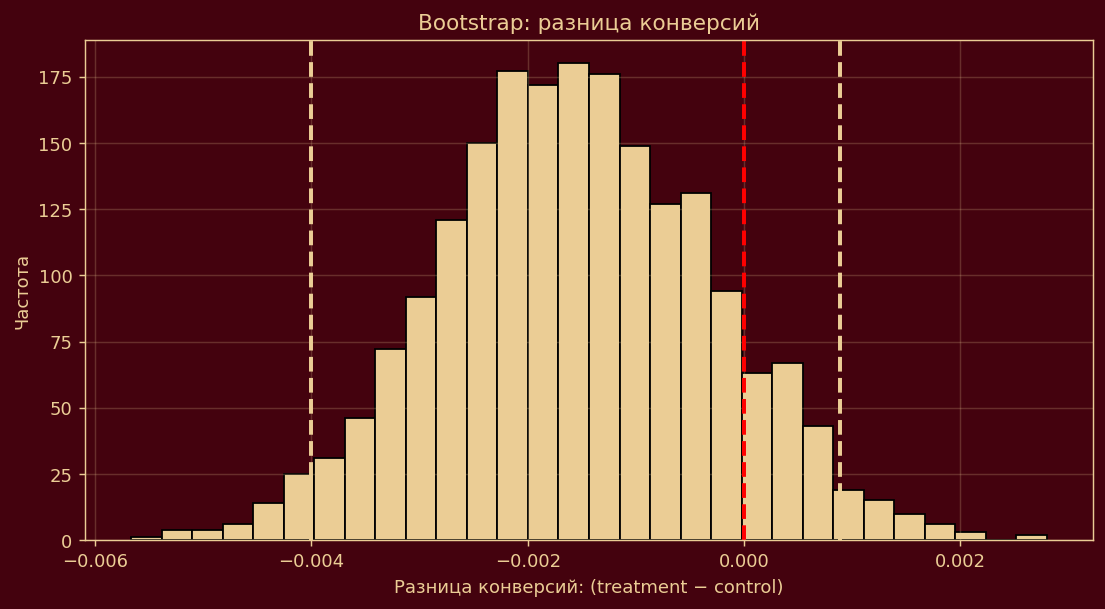

In [588]:
plt.figure(figsize=(10,5))
plt.hist(d, bins=30, edgecolor = 'black')
plt.axvline(0, linestyle = '--', color = 'red')  #нет эффекта - 0
plt.axvline(lo, linestyle = '--') #перцентили
plt.axvline(hi, linestyle = '--')
plt.xlabel('Разница конверсий: (treatment − control)')
plt.ylabel('Частота')
plt.title('Bootstrap: разница конверсий')
plt.show()


На графике визуально видно, что ноль находится внутри основной массы распределения, что показывает, что данные и правда допускают ситуацию, где разница конверсий равна нулю, несмотря на то, что чаще всего разница отрицательная (так как центр лежит левее нуля).

**Вывод:**

Визуальный анализ bootstrap-распределения разницы конверсий подтверждает результаты теста: значение 0 не лежит в хвосте распределения, а значит, статистически значимого отличия между группами не обнаружено.